# Stochastic Gradient Descent Distributed
Now we need to distribute our training
1. First we need to start an ipcluster with multiple nodes
2. Then we configure torch.distributed as the nodes need to know how to find each other
    - One way of doing this is setting up environment variables MASTER_ADDR and MASTER_PORT to open a port on the first node.
      This TCP port will be only used for lookup. The actual communication will be done through NCCL.
    - Also WORLD_SIZE, LOCAL_RANK and RANK need to be set correctly to identify each peer. 

In [1]:
import socket
import ipcmagic
%ipcluster start -n 2 --mpi

  0%|          | 0/2 [00:00<?, ?engine/s]

In [2]:
%%px
import os
import sys
import socket
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn.parameter import Parameter
from tqdm import trange, tqdm

from line_regression import get_line_data, plot_regression, DynamicRegressionPlot

# Setup environment for torch.distributed.init_process_group
os.environ['MASTER_PORT'] = '29500'
os.environ['WORLD_SIZE'] = os.environ['SLURM_NNODES']
os.environ['LOCAL_RANK'] = '0'  # single GPU per node
os.environ['RANK'] = os.environ['SLURM_NODEID']

world_size = int(os.environ['SLURM_NNODES'])
rank = int(os.environ['SLURM_NODEID'])

print(socket.gethostname(), rank, world_size)

[stdout:0] nid07206 0 2
[stdout:1] nid07207 1 2


In [3]:
master_address = f"'{socket.gethostname()}'"
%px os.environ['MASTER_ADDR'] = $master_address
%px print(os.environ['MASTER_ADDR'])

[stdout:0] nid07206
[stdout:1] nid07206


In [4]:
%%px
import torch.distributed as dist

if not dist.is_initialized():
    # Environment variable initialization
    dist.init_process_group(backend="nccl")

<mark>Exercise</mark>
Distribute the training
1. Go through the code below and replace the TODO comments with the collective functions from torch.distributed
2. Make sure the results (parameters, gradients, etc) correspond to your expectations.

#### Collective functions cheat sheet:
- dist.broadcast(tensor, src, group=None, async_op=False)
  - Broadcasts the tensor from `src` to the whole group.
  - e.g.: `dist.broadcast(W, src=0)` # all GPU's get the Tensor W from rank 0
- dist.all_reduce(tensor, op=ReduceOp.SUM, group=None, async_op=False)
  - Reduces the tensor data across all machines in such a way that all get the final (bitwise identical) result.

Check https://pytorch.org/docs/stable/distributed.html for more info and additional methods e.g. reduce, gather, all_gather, scatter, reduce_scatter and all_to_all 

In [5]:
%%px
# get data
nsamples = 1000
x_train, y_train, ground_truth = get_line_data(nsamples)

# GPU Tensors
device = 'cuda'
x = torch.tensor(x_train, dtype=torch.float32, device=device)
y = torch.tensor(y_train, dtype=torch.float32, device=device)

In [6]:
%%px
# Init model
slope = Parameter(torch.randn([1], device=device))
offset = Parameter(torch.randn([1], device=device))
parameters = [slope, offset]

### Task 1: Broadcast parameters from rank=0 to all others
with torch.no_grad():
    ### make sure all ranks have the same parameters
    for p in parameters:
        ## TODO

    print('Rank:', dist.get_rank(), [p.item() for p in parameters])

[stdout:0] 
nid07206:25887:25887 [0] NCCL INFO Bootstrap : Using [0]ipogif0:148.187.60.95<0>
nid07206:25887:25887 [0] NCCL INFO NET/Plugin : No plugin found (libnccl-net.so), using internal implementation
nid07206:25887:25887 [0] NCCL INFO NET/IB : No device found.
nid07206:25887:25887 [0] NCCL INFO NET/Socket : Using [0]ipogif0:148.187.60.95<0>
nid07206:25887:25887 [0] NCCL INFO Using network Socket
NCCL version 2.7.8+cuda11.1
nid07206:25887:25921 [0] NCCL INFO Channel 00/02 :    0   1
nid07206:25887:25921 [0] NCCL INFO Channel 01/02 :    0   1
nid07206:25887:25921 [0] NCCL INFO threadThresholds 8/8/64 | 16/8/64 | 8/8/64
nid07206:25887:25921 [0] NCCL INFO Trees [0] 1/-1/-1->0->-1|-1->0->1/-1/-1 [1] -1/-1/-1->0->1|1->0->-1/-1/-1
nid07206:25887:25921 [0] NCCL INFO Setting affinity for GPU 0 to ffffff
nid07206:25887:25921 [0] NCCL INFO Channel 00 : 1[2000] -> 0[2000] [receive] via NET/Socket/0
nid07206:25887:25921 [0] NCCL INFO Channel 00 : 0[2000] -> 1[2000] [send] via NET/Socket/0
nid0

[stderr:0] 
libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/22.3-7.0.2.1_2.72__g42f5f32b.ari/etc/libibverbs.d'.
[stderr:1] 
libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/22.3-7.0.2.1_2.72__g42f5f32b.ari/etc/libibverbs.d'.


In [7]:
%%px --noblock -o training

iters = 100
batch_size = 100
lr = 0.02 * batch_size**0.5
history = []

for i in trange(iters, file=sys.__stdout__):
    # Sample batch
    batch = torch.randint(len(y), [batch_size])
    
    # Calculate loss
    y_hat = slope*x[batch] + offset
    error = (y_hat - y[batch])**2
    mse = error.mean()
    
    # Calculate gradients
    mse.backward()

    # Training step
    with torch.no_grad():
        for p in parameters:
            ### Task 2: Average gradients with all_reduce
            ### make sure all ranks have the same gradients
            ## TODO

            # SGD step
            p -= lr*p.grad
            # Clear gradients
            p.grad = None
        history.append([slope.item(), offset.item(), mse.item()])

print(dist.get_rank(), [p.item() for p in parameters])

<AsyncResult: execute>

In [8]:
# watch the output in real time
ipcmagic.utilities.watch_asyncresult(training)

[ stdout 0 ]
100%|██████████| 100/100 [00:01<00:00, 66.56it/s]0 [1.9697377681732178, -0.008587068878114223]

[ stdout 1 ]
100%|██████████| 100/100 [00:01<00:00, 66.57it/s]1 [1.9697377681732178, -0.008587068878114223]



[stdout:1] 1 [1.9697377681732178, -0.008587068878114223]
[stdout:0] 0 [1.9697377681732178, -0.008587068878114223]


[output:1]

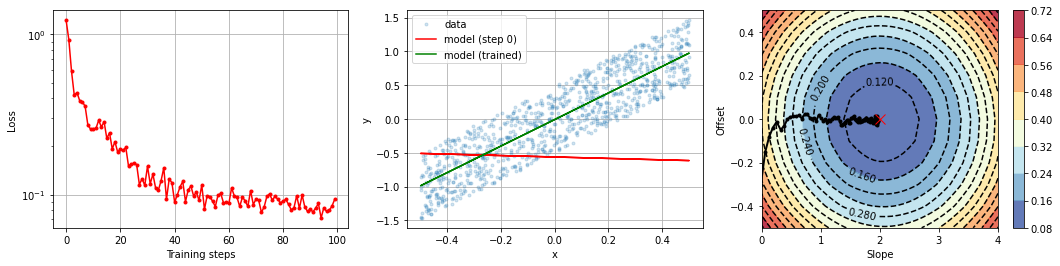

[output:0]

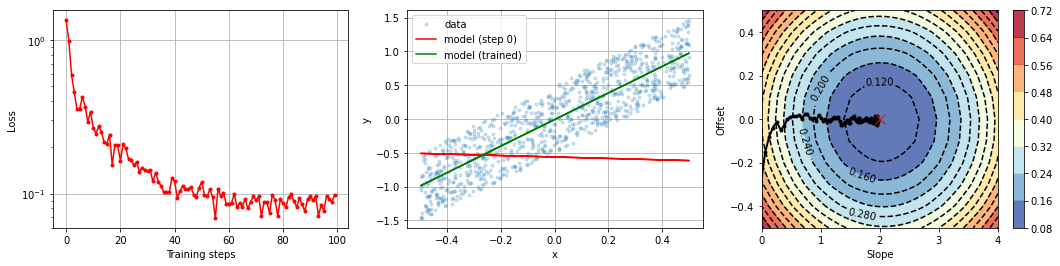

In [9]:
%%px

plot_regression(history, x_train, y_train, ground_truth)
print(dist.get_rank(), [p.item() for p in parameters])

In [10]:
%ipcluster stop